### Create two random variables statistically independent, but with scale difference

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# Features within different scales is a problem. Let us start with a small difference in scale.  
scale_difference = 2

nsamples = 5000 # number of samples
x1       = np.random.rand(nsamples) # random variable 1 
x2       = scale_difference*np.random.rand(nsamples) # random variable 2 
X        = np.column_stack((x1,x2))
print(X)

[[0.63309589 1.27980039]
 [0.28657857 0.52927725]
 [0.69036687 1.50098395]
 ...
 [0.10417688 0.43996099]
 [0.87990774 0.36855239]
 [0.25060358 0.48415561]]


### Create a random variable y that depends on the random variables x1 and x2

In [2]:
Y      = X[:,0]**2 + X[:,1]**2
print(Y)

[2.03869944 0.36226169 2.72955922 ... 0.20441849 0.9100685  0.2972088 ]


### To reduce the effect of scale differences between features, it is recommended to normalize them within [0,1] and not use z-score normalization for regression. Let us start with linear normalization.  

In [3]:
# Estimate the parameters for linear and z-score normalizations of the input features
x1_min = X[:,0].min()
x2_min = X[:,1].min()
x1_max = X[:,0].max()
x2_max = X[:,1].max()
y_min  = Y.min()
y_max  = Y.max()
x1_mean = X[:,0].mean()
x2_mean = X[:,1].mean()
x1_std  = X[:,0].std()
x2_std  = X[:,1].std() 

# Apply normalization

# Z-score
#X[:,0]  = (X[:,0] - x1_mean)/(x1_std + 0.1)
#X[:,1]  = (X[:,1] - x2_mean)/(x2_std + 0.1)

# Linear
X[:,0]   = (X[:,0]-x1_min)/(x1_max-x1_min)
X[:,1]   = (X[:,1]-x2_min)/(x2_max-x2_min)

# You must linearly normalize Y. Recall to revert the process after prediction.  
Y        = (Y-y_min)/(y_max-y_min)

### Visualize the manifold y = f(x1,x2) for regression

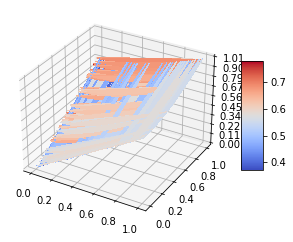

In [4]:
fig, ax  = plt.subplots(subplot_kw={"projection": "3d"})
Px1, Px2 = np.meshgrid(X[:,0], X[:,1])
Py       = np.sqrt(Px1**2 + Px2**2)
Py       = (Py - Py.min())/(Py.max()-Py.min())
surf     = ax.plot_surface(Px1, Px2, Py, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_zlim(0, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### Create a neural network model for regression 

In [5]:
import torch
from torch import nn as nn
import torch.optim as optim

# Define a MLP model for regression 

class NeuralNet(nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()
        self.regressor = nn.Sequential(
            nn.Linear(in_features=2, out_features=100, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=100, out_features=1, bias=True)    
        )
        self.weights_init()

    def forward(self, x):
        y = self.regressor(x)
        return y

    def weights_init(self):
        for x in self.modules():
            if isinstance(x, nn.Linear):
                torch.nn.init.xavier_uniform_(x.weight.data)
                if (x.bias is not None): 
                    x.bias.data.zero_()

    
# Create the model with cross entropy loss and statistical gradient descendant optimizer

model     = NeuralNet()
print(model)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

NeuralNet(
  (regressor): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=100, out_features=1, bias=True)
  )
)


### Train the model

In [6]:
# Convert the training set from numpy to tensor

X = torch.FloatTensor(X)
Y = torch.FloatTensor(Y)

# Train the model

model.train()
epochs   = 500 # if you increase it, then the convergence happens even without forcing the above initialization

for epoch in range(epochs):
    optimizer.zero_grad() # set gradients to zero
    # Forward pass
    y_pred = model(X) 
    # Compute Loss
    loss = criterion(y_pred.squeeze(), Y)
    
    #print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

### Verify the results: the model should be able to estimate y given (x1,x2). 

In [7]:
x1 = np.random.rand(1)[0] 
x2 = scale_difference*np.random.rand(1)[0]
y  = (x1**2 + x2**2)

# For z-score
#x1 = (x1 - x1_mean)/(x1_std + 0.1)
#x2 = (x2 - x2_mean)/(x2_std + 0.1)

# For linear
x1 = (x1 - x1_min) / (x1_max - x1_min)
x2 = (x2 - x2_min) / (x2_max - x2_min)

# Predict
model.eval()
x      = torch.FloatTensor([x1, x2])
y_pred = model(x)

# Revert prediction into the desired scale
y_pred = y_pred.detach().numpy()[0]
y_pred = (y_pred * (y_max - y_min))  + y_min

print(y_pred, y, "squared error=", (y_pred-y)**2)

3.54540531019701 3.860139454561288 squared error= 0.09905758162871414


### Conclusion: as you increase the scale difference, normalization might not be enough. 